In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv(r'.\data\text.csv')

In [2]:
data.head(10)

,text,label
0,"['非', '财务', '纠淼', '牟', '莆', '窆', '芾', '沙盘', '模...",0
1,"['讲', '的', '是', '孔子', '后人', '的', '故事', '一个', '...",1
2,"['尊敬', '的', '贵', '公司', '财务', '经理', '负责人', '您好'...",0
3,"['贵', '公司', '负责人', '经理', '财务', '您好', '深圳市', '华...",0
4,"['这是', '一封', '格式', '信件', '广告', '网络电话', '包年', '...",0
5,"['贵', '公司', '经理', '财务', '您好', '深圳市', '春洋', '贸易...",0
6,"['那', '他', '为什么', '不', '愿意', '起诉', '既然', '这样',...",1
7,"['尊敬', '的', '负责人', '经理', '财务', '您好', '我', '是',...",0
8,"['您好', '以下', '是', '特别', '为', '阁下', '发', '的', '...",0
9,"['我', '觉得', '负债', '不要紧', '最', '重要', '的', '是', ...",1


In [4]:
# 词嵌入,构建词汇表
from collections import Counter

def build_Vcab(text,max_vcab=5000):
    '''
    从文本数据中，构建词汇表
    
    prarmeter:
    -------------------------
    text:array of list
    包含文本的数据集
    max_vcab:int
    词汇表的最大长度
    '''
    vcab = Counter()
    for text_list in text:
        # 根据列表中的单词，更新列表数量
        vcab.update(text_list)
    # 创建词汇表映射
    word2idx = {word:index+2 for index , (word,count) in enumerate(vcab.most_common(max_vcab-2))}
    word2idx['<unk>'] = 1
    word2idx['<pad>'] = 0
    return word2idx

word2idx = build_Vcab(data.text)

In [5]:
word2idx

{"'": 2,
 ',': 3,
 ' ': 4,
 '的': 5,
 '我': 6,
 '有': 7,
 '一': 8,
 '是': 9,
 '不': 10,
 '人': 11,
 '了': 12,
 '司': 13,
 '业': 14,
 '公': 15,
 '在': 16,
 '理': 17,
 '个': 18,
 '发': 19,
 '大': 20,
 '可': 21,
 '电': 22,
 '中': 23,
 '以': 24,
 '国': 25,
 '上': 26,
 '为': 27,
 '会': 28,
 '你': 29,
 '务': 30,
 '和': 31,
 '用': 32,
 '时': 33,
 '要': 34,
 '作': 35,
 '网': 36,
 '这': 37,
 '来': 38,
 '管': 39,
 '生': 40,
 '好': 41,
 '系': 42,
 '能': 43,
 '工': 44,
 '他': 45,
 '多': 46,
 '就': 47,
 '到': 48,
 '如': 49,
 '对': 50,
 '商': 51,
 '学': 52,
 '分': 53,
 '本': 54,
 '成': 55,
 '方': 56,
 '信': 57,
 '们': 58,
 '家': 59,
 '实': 60,
 '您': 61,
 '与': 62,
 '开': 63,
 '年': 64,
 '票': 65,
 '地': 66,
 '品': 67,
 '经': 68,
 '自': 69,
 '等': 70,
 '现': 71,
 '也': 72,
 '机': 73,
 '企': 74,
 '说': 75,
 '过': 76,
 '点': 77,
 '通': 78,
 '心': 79,
 '行': 80,
 '天': 81,
 '子': 82,
 '么': 83,
 '真': 84,
 '后': 85,
 '产': 86,
 '合': 87,
 '下': 88,
 '市': 89,
 '件': 90,
 '元': 91,
 '出': 92,
 '还': 93,
 '全': 94,
 '进': 95,
 '很': 96,
 '月': 97,
 '得': 98,
 '程': 99,
 '都': 100,
 '联': 101,
 '力': 

In [6]:
# 构建数据集
import torch
from torch.utils.data import Dataset,DataLoader

class TextDataset(Dataset):
    def __init__(self,texts,labels,word2idx,max_len):
        '''
        初始化完成文本单词到索引的转换
        '''
        self.labels = np.array(labels,dtype=np.float32)
        t = []
        for text_list in texts:
            indices = [word2idx.get(word,1) for word in text_list]
            if len(indices)>max_len:
                indices = indices[:max_len]
            else:
                indices += [0]*(max_len-len(indices))
            t.append(indices)
        self.text = torch.LongTensor(t)

    def __len__(self):
        return len(self.text)
    
    def __getitem__(self,idx):
        text = self.text[idx]
        label = self.labels[idx]
        return text,label

dataset = TextDataset(data.text,data.label,word2idx,512)

In [8]:
print(dataset[5][0].shape,dataset[5][1].shape)

torch.Size([512]) ()


In [13]:
import torch.nn as nn
import torch.nn.functional as F
# 定义模型

class EmailLSTM(nn.Module):

    def __init__(self,vocab_size,embeding_dim,hidden_size):
        '''
        vecab_size:文本词汇长度
        embeding_dim:词嵌入长度
        hidden_size: RNN个数
        output_size:分类数
        '''
        super().__init__()
        self.embeding = nn.Embedding(vocab_size,embeding_dim,padding_idx=0)
        # 如，输入的词有512个，那么就会有512行向量，embeding_dim则决定了词嵌入向量的列
        # 即，通过词嵌入，一个（batch_size，seq_length）的词，会变成（batch_size,seq_size,embeding_dim）
        # padding_idx:指填充单词的索引，当指定该词后，在反向传播中，不会更新
        # 输出形状当前为（batch_size,seq_length,embeding_dim）,正好为rnn输入形状。embeding_dim，也可以看作特征数量
        self.lstm = nn.LSTM(embeding_dim,hidden_size,batch_first=True)
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x):
        # embeding的输入为二位张量（batch_size,seq_length)
        # 输出为（batch_size,seq_length,embeding_dim）
        embeded_x = self.embeding(x)
        # output:shape = (batch_size,seq_length,hidden_size)
        output,(hiddens,cell) = self.lstm(embeded_x)
        # 截取outPut最后一个时间步数据，通过linear后，输出（batch_size,1）
        x = self.fc(output[:,-1,:])
        return F.sigmoid(x)
    

In [15]:
# 设置超参数
# 文本序列最大长度，根据文本数据分析得到。文本长度绝大多数在100以上，1000以下，因此可以设置为500，再根据结果调整
from sklearn.model_selection import train_test_split
from torch.optim import Adam
max_length = 500
batch_size = 32
embed_dim = 128
hidden_szie = 64
epochs = 30
max_vocab_size = 5000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_train,x_test,y_train,y_test = train_test_split(data['text'],data['label'],random_state=0,test_size=0.25)
word2idx = build_Vcab(x_train,max_vcab=max_vocab_size)
train_dataset = TextDataset(x_train,y_train,word2idx,max_length)
test_dataset = TextDataset(x_test,y_test,word2idx,max_length)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

# 创建模型
model = EmailLSTM(vocab_size=len(word2idx),embeding_dim=embed_dim,hidden_size=hidden_szie).to(device)

criterion = nn.BCELoss()
optimizer = Adam(model.parameters())

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct =0
    for inputs,labels in train_loader:
        inputs,labels = inputs.to(device),labels.to(device)

        # 前向传播
        output = model(inputs).flatten()
        # 计算损失
        loss = criterion(output,labels)
        # 反向传播
        loss.backward()
        optimizer.step()
        # 梯度清零
        optimizer.zero_grad()

        train_loss += loss.item()
        y_pre = (output >0.5).float()
        train_correct += (y_pre == labels).sum().item()
    train_loss /= len(train_loader)
    train_accuracy = train_correct/len(train_loader.dataset)


    model.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for inputs,labels in test_loader:
            inputs,labels = inputs.to(device),labels.to(device)

            # 前向传播
            output = model(inputs).flatten()
            # 计算损失
            loss = criterion(output,labels)


            test_loss += loss.item()
            y_pre = (output > 0.5).float()
            test_correct += (y_pre == labels).sum().item()
        test_loss /= len(test_loader)
        test_accuracy = test_correct/len(test_loader.dataset)

    print(f'{epoch+1}/{epochs}',
          f'train_loss={train_loss:.4f},train_acc={train_accuracy:.4f}',
          f'test_loss={test_loss:.4f},test_acc={test_accuracy:.4f}')

1/30 train_loss=0.3562,train_acc=0.8458 test_loss=0.1782,test_acc=0.9343
2/30 train_loss=0.1173,train_acc=0.9572 test_loss=0.0933,test_acc=0.9651
3/30 train_loss=0.0677,train_acc=0.9786 test_loss=0.0663,test_acc=0.9792
4/30 train_loss=0.0463,train_acc=0.9866 test_loss=0.0577,test_acc=0.9851
5/30 train_loss=0.0337,train_acc=0.9913 test_loss=0.0510,test_acc=0.9868
6/30 train_loss=0.0267,train_acc=0.9929 test_loss=0.0474,test_acc=0.9888
7/30 train_loss=0.0231,train_acc=0.9939 test_loss=0.0546,test_acc=0.9869
8/30 train_loss=0.0173,train_acc=0.9959 test_loss=0.0465,test_acc=0.9898
9/30 train_loss=0.0140,train_acc=0.9968 test_loss=0.0536,test_acc=0.9869
10/30 train_loss=0.0125,train_acc=0.9969 test_loss=0.0412,test_acc=0.9903
11/30 train_loss=0.0104,train_acc=0.9974 test_loss=0.0510,test_acc=0.9900
12/30 train_loss=0.0106,train_acc=0.9974 test_loss=0.0437,test_acc=0.9911
13/30 train_loss=0.0096,train_acc=0.9978 test_loss=0.0455,test_acc=0.9913
14/30 train_loss=0.0087,train_acc=0.9979 test_l

In [18]:
# 保存模型
torch.save(model.state_dict(),'.\model\EmailRnn.pth')

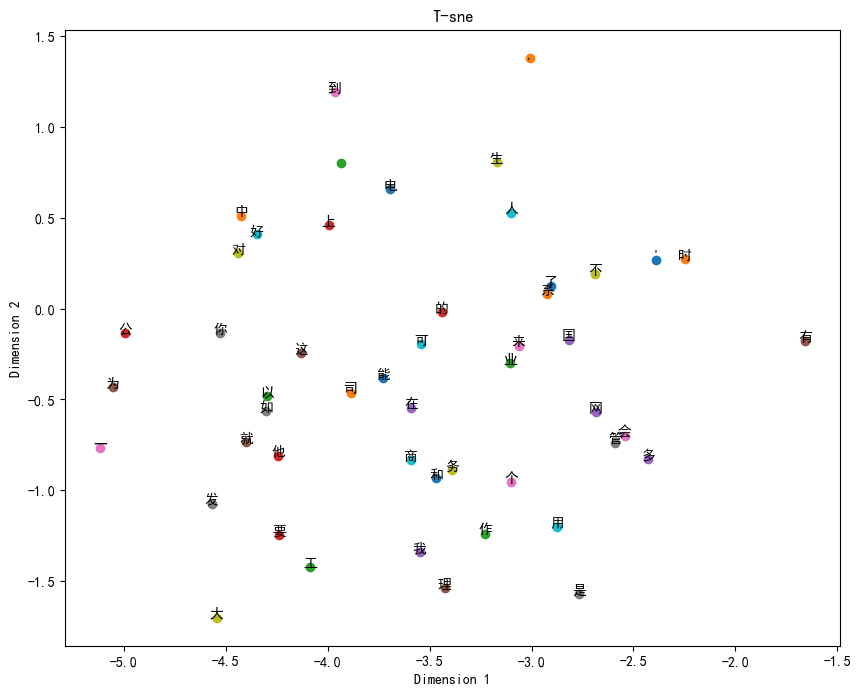

In [ ]:
# 词向量可视化
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 提取词嵌入层
embeding_weigth = model.embeding.weight.cpu().detach() 
# detach:对计算图中张量进行复制。计算图中张量与转到cpu中的ndarry数组共享内存，因此防止修改计算图，对数据进行复制

# 创建索引到词的映射
idx2word = {v:k for k,v in word2idx.items()}
# 选择词频最高的50个单词
top_n= 50  
index = np.arange(2,top_n+2,1)
embedings = embeding_weigth[index]

# 使用TSNE降维
tsne=TSNE(n_components = 2,random_state=0)
reduced_embedings = tsne.fit_transform(embedings)

# 可视化
fig,ax = plt.subplots(figsize = (10,8))
for i ,label in enumerate(index):
    x1,x2 = reduced_embedings[i,:]
    ax.scatter(x1,x2)
    ax.annotate(idx2word[label],(x1,x2),ha='center')
ax.set_title('T-sne')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
plt.show()


In [30]:
embedings.shape

torch.Size([50, 128])